## import libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

# Metadynamics Simulation (Untempered)

### File locations for this simulation ->

In [2]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf1/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat"

### load the trajectory for the given atom selction ->

### load the data from COLVAR file ->

In [114]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

In [115]:
## get the FE landscape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

# use weights from metad_rbias
hist, xedges, yedges = np.histogram2d(phi, psi, bins=30, range=[range_,range_], density=True, weights=np.exp(metad_rbias/kbt))
xgrids = (xedges[1:] + xedges[:-1])/2.0
ygrids = (yedges[1:] + yedges[:-1])/2.0

xx, yy = np.meshgrid(xgrids, ygrids)
fe = -kbt*np.log(hist)
fe -= fe.min()

### load the final bias ->

### get the weights for each case ->

### load the clustered objects (uniform weights) ->

### load the clustered objects (metad.rbias weights) ->

In [116]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf1/


In [3]:
wsgmm_list_rbias = []
for i in range(3):
    with open(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/wsgmm_%dstate.pickle"%(i+2), "rb") as fo:
        wsgmm = pickle.load(fo)
        wsgmm_list_rbias.append(wsgmm)

In [8]:
print(wsgmm_list_rbias[0].train_frame_log_likelihood)
print(wsgmm_list_rbias[0].log_likelihood)

[54.17374875 53.17710591 56.07087064 ... 36.87847597 42.22014401
 55.43002123]
54.871117685141854


In [118]:
train = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

In [119]:
# load train and cv data where we didn't use weights (or uniform weights)

train_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean_wout = np.mean(train_wout, axis=1)
train_std_wout = np.std(train_wout, axis=1)

# cv
cv_mean_wout = np.mean(cv_wout, axis=1)
cv_std_wout = np.std(cv_wout, axis=1)

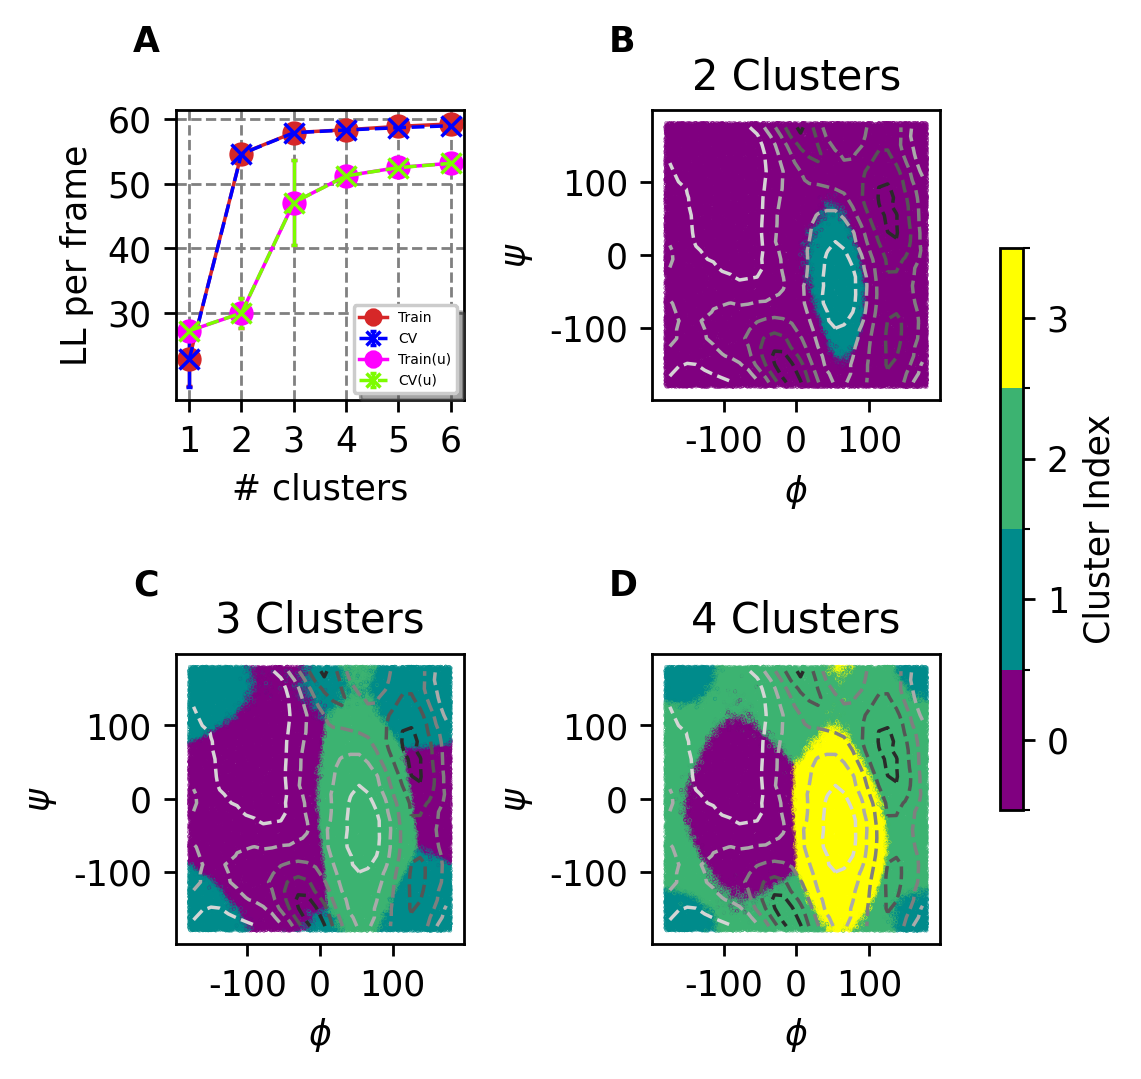

In [120]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import string 

fig, axs = plt.subplots(2,2, figsize=(4.5, 4.5), dpi=250)
axs = axs.reshape([-1])

colors = ['purple', 'darkcyan', 'mediumseagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)


#0
axs[0].text(-0.15, 1.2, "A", fontsize=10, fontweight="bold", transform=axs[0].transAxes)
axs[0].set_xlabel("# clusters")
axs[0].set_ylabel("LL per frame")
axs[0].set_xticks(np.arange(1,7))
axs[0].set_xticklabels(np.arange(1,7))  # change the fontsize on tick labels
axs[0].set_yticks([30,40,50,60])
axs[0].set_yticklabels([30,40,50,60])

axs[0].errorbar(np.arange(1,7), train_mean, train_std, fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
axs[0].errorbar(np.arange(1,7), cv_mean, cv_std, fmt='--x', color="blue", lw=1, capsize=1, label="CV")

axs[0].errorbar(np.arange(1,7), train_mean_wout, train_std_wout, fmt='-o', color="magenta", lw=1, capsize=1, label="Train(u)")
axs[0].errorbar(np.arange(1,7), cv_mean_wout, cv_std_wout, fmt='--x', color="lawngreen", lw=1, capsize=1, label="CV(u)")

axs[0].legend(loc="lower right", fontsize=4.0, markerscale=0.7, shadow=True)
axs[0].grid(which='major', axis='both', color='#808080', linestyle='--')

labels = ["B", "C", "D"]
for i in range(3):
    if i == 0 or i == 2:
        axs[i+1].set_yticks([])
    axs[i+1].text(-0.15, 1.2, labels[i], fontsize=10, fontweight="bold", transform=axs[i+1].transAxes)
    axs[i+1].set_title("%d Clusters"%(i+2))
    axs[i+1].set_xlabel("$\phi$")
    axs[i+1].set_ylabel("$\psi$")
    axs[i+1].set_yticks([-100,0,100])
    axs[i+1].set_yticklabels([-100,0,100])
    axs[i+1].set_xticks([-100,0,100])
    axs[i+1].set_xticklabels([-100,0,100])
    axs[i+1].contour(xx, yy, fe.T, cmap="binary", linestyles="--", levels=5, linewidths=1.0)
    im = axs[i+1].scatter(phi, psi, c=wsgmm_list_rbias[i].cluster_ids, marker=".", s=0.05, cmap=cmap, norm=norm)

# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')
plt.tight_layout(rect=[0.0,0.0,0.88,1.0])
                                           
plt.savefig("untempered_all_rbias_weights_updated.png")

# Metadynamics Simulation (BF=10)

### File locations for this simulation ->

In [121]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"

### load the trajectory for the given atom selction ->

### load the data from COLVAR file ->

In [122]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

### load the final bias ->

In [123]:
metad_fbias = np.loadtxt(data_path+"colvar_reweight", usecols=3)
metad_fbias -= metad_fbias.min()

In [124]:
# list of biases 
biases = [metad_bias, metad_rbias, metad_fbias]

### calculate the FES for different choice of weights ->

In [125]:
nbins = 30
range_ = [-180,180]
fes_data = []
for i in range(4):
    
    if i == 0:
        # not using any weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True)
    else:
        # using proper weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True, weights=np.exp(biases[i-1]/kbt))
    
    xgrids = (xedges[1:] + xedges[:-1])/2.0
    ygrids = (yedges[1:] + yedges[:-1])/2.0
    
    xx, yy = np.meshgrid(xgrids, ygrids)
    fe = -kbt*np.log(hist)
    fe -= fe.min()
    
    out_arr = [xx, yy, fe]
    fes_data.append(out_arr)
fes_data = np.array(fes_data)
print(fes_data.shape)

(4, 3, 30, 30)


### load the clustered objects for different weights and different clusters ->

In [126]:
wsgmm_list = []

# loop over different weights (w1, w2 and w3)
for i in range(3):
    objs = []
    
    # loop over different clusters (2 to 6)
    for j in range(5):
        
        # load pickled object
        with open(data_path+"w%d/run_with_v1.6.1/kabsch_thresh_1e-1/wsgmm_%dstate_nattempts_40.pickle"%(i+1, j+2), "rb") as fo:
            obj = pickle.load(fo)
        
        objs.append(obj)
    
    wsgmm_list.append(objs)
        
wsgmm_list = np.array(wsgmm_list)
print(wsgmm_list.shape)

(3, 5)


In [127]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/


### load the clustered objects obtained from using uniform weights ->

In [128]:
objs_uniform = []
for i in range(5):
    with open(data_path+"run_with_v1.6.1/wsgmm_%dstate_wout_weights_nattempts_40.pickle"%(i+2), "rb") as fo:
        obj_ = pickle.load(fo)
    objs_uniform.append(obj_)
    
objs_uniform = np.array(objs_uniform)

print(objs_uniform.shape)

(5,)


In [129]:
all_wsgmm = np.concatenate([objs_uniform.reshape(1,5), wsgmm_list], axis=0)
print(all_wsgmm.shape)

(4, 5)


In [130]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/


### load the train and cv files for each case ->

In [131]:
paths = ["run_with_v1.6.1", "w1/run_with_v1.6.1", "w2/run_with_v1.6.1", "w3/run_with_v1.6.1"]
#paths = ["w1", "w2", "w3"]

mean_data = []
std_data = []

for i in range(4):
#for i in range(3):    
    
    # load
    train = np.loadtxt(data_path+paths[i]+"/train.dat")[:,1:]
    cv = np.loadtxt(data_path+paths[i]+"/cv.dat")[:,1:]
    
    # train
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    
    # cv
    cv_mean = np.mean(cv, axis=1)
    cv_std = np.std(cv, axis=1)
    
    # append
    mean_data.append([train_mean, cv_mean])
    std_data.append([train_std, cv_std])
    
mean_data = np.array(mean_data)
std_data = np.array(std_data)

In [132]:
print(mean_data.shape)
print(std_data.shape)

(4, 2, 6)
(4, 2, 6)


In [133]:
print(fes_data.shape)
print(all_wsgmm.shape)

(4, 3, 30, 30)
(4, 5)


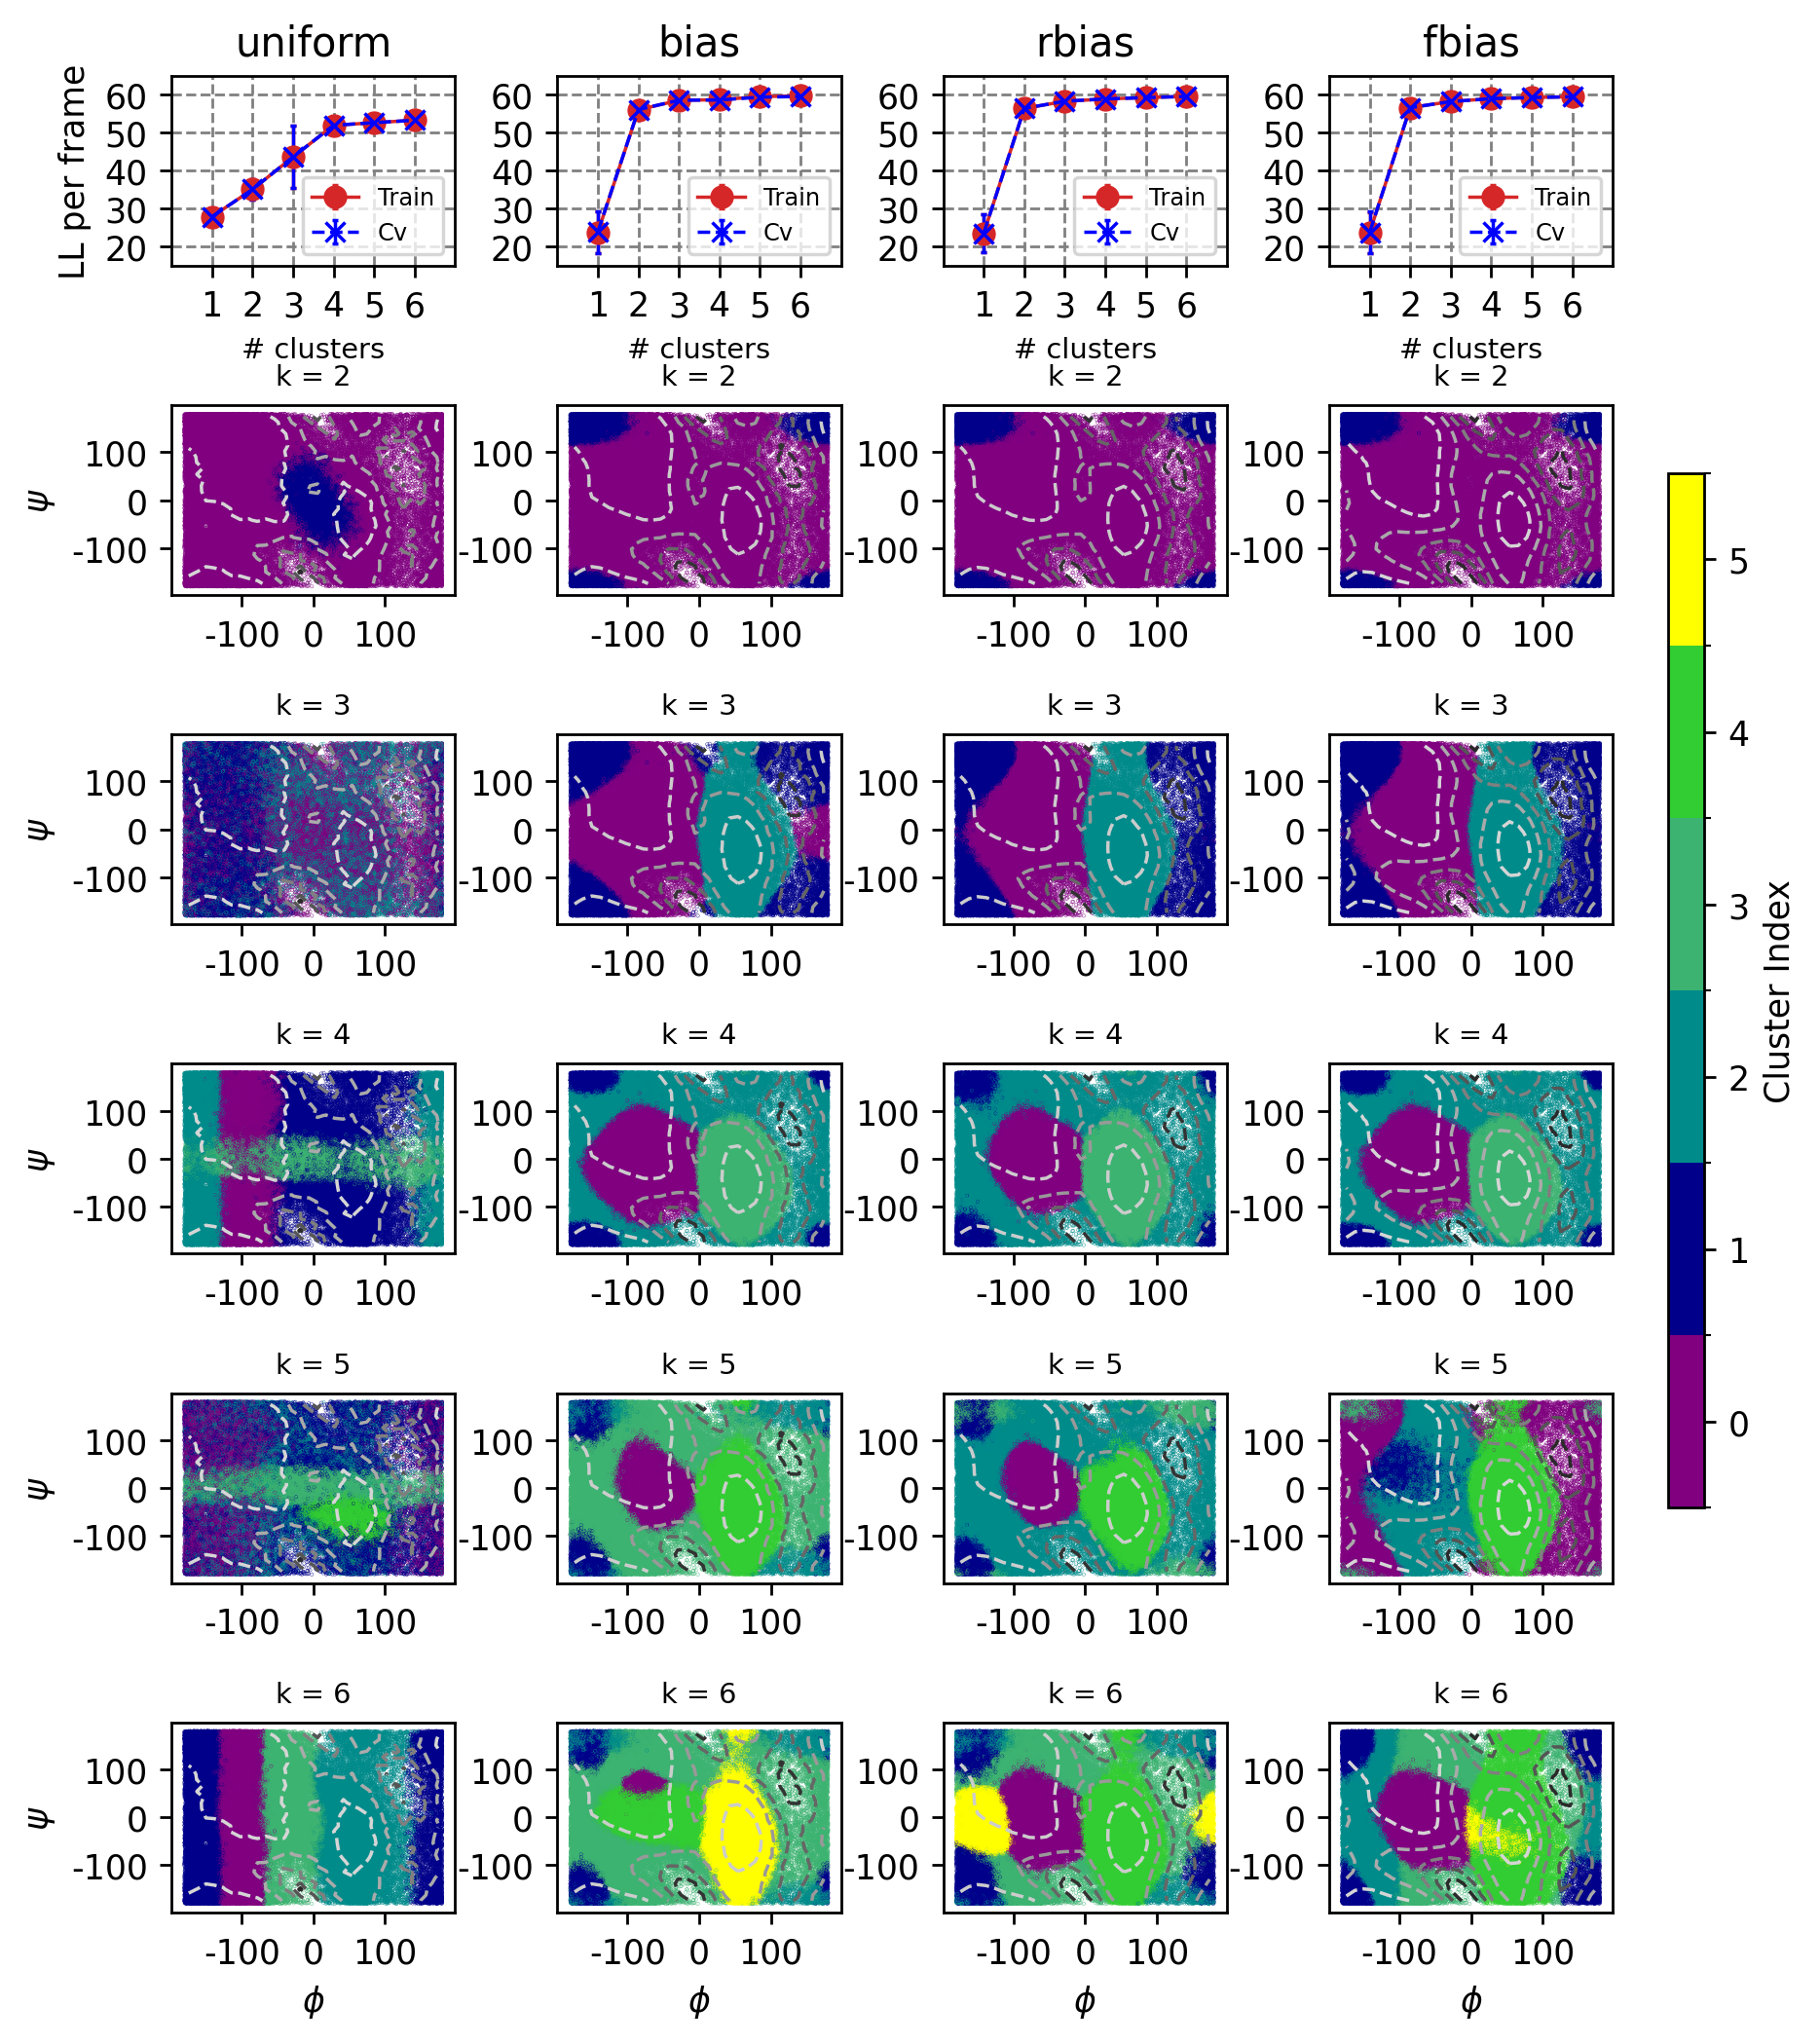

In [134]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkblue', 'darkcyan', 'mediumseagreen', 'limegreen','yellow']
cluster_boundaries = [0, 1, 2, 3, 4, 5, 6]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

fig, axs = plt.subplots(6, 4, figsize=(7.5,8.5), dpi=250)
titles = ["uniform", "bias", "rbias", "fbias"]

# put the cluster scans
for i in range(4):
    if i == 0:
        axs[0,i].set_ylabel("LL per frame")
    axs[0,i].set_xlabel("# clusters", fontsize="small")
    axs[0,i].set_title(titles[i])
    
    # set limits
    axs[0,i].set_xlim(0,7)
    axs[0,i].set_ylim(15,65)
    
    # set y-ticks
    axs[0,i].set_yticks([20,30,40,50,60])
    axs[0,i].set_yticklabels([20,30,40,50,60])
    
    # set x-ticks
    axs[0,i].set_xticks(np.arange(1,7))
    axs[0,i].set_xticklabels(np.arange(1,7))
    
    # plot
    axs[0,i].errorbar(np.arange(1,7), mean_data[i,0,:], std_data[i,0,:], fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
    axs[0,i].errorbar(np.arange(1,7), mean_data[i,1,:], std_data[i,1,:], fmt='--x', color="blue", lw=1, capsize=1, label="Cv")
    
    axs[0,i].legend(loc="lower right", fontsize="x-small")
    axs[0,i].grid(which='major', axis='both', color='#808080', linestyle='--')

# put the psi labels
for i in range(1,6):
    axs[i,0].set_ylabel("$\psi$")


# put the scatter plots
# loop over different choice of weights
for i in range(4):
    
    axs[5,i].set_xlabel("$\phi$")
    
    # loop over the different size of clusters
    for j in range(1,6):
        
        axs[j,i].set_title("k = %d"%(j+1), fontsize="small")
        
        # set xticks
        axs[j,i].set_xticks([-100,0,100])
        axs[j,i].set_xticklabels([-100,0,100])
        
        # set yticks
        axs[j,i].set_yticks([-100,0,100])
        axs[j,i].set_yticklabels([-100,0,100])
        
        # plot
        axs[j,i].contour(fes_data[i,0,:,:], fes_data[i,1,:,:], fes_data[i,2,:,:].T, cmap="binary", levels=5, linestyles="--", linewidths=1.0)
        im = axs[j,i].scatter(phi, psi, c=all_wsgmm[i,j-1].cluster_ids, cmap=cmap, marker=".", s=0.05, norm=norm)
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.265, 0.02, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5,6,1))
cbar.set_ticklabels(np.arange(6))

# Optionally, add a label to the colorbar
cbar.set_label('Cluster Index')

plt.tight_layout(rect=[0,0,0.91,1.0], h_pad=0, w_pad=0.05)
        
plt.savefig("bf10_all_updated.png")

### calculate the KL divergences between FEs predicted from GMM and metad sum_hills FE

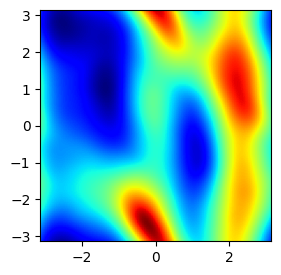

In [135]:
metad_fe_sumhills = np.loadtxt(os.path.join(data_path,"2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt"))[:,2]
metad_fe_sumhills = metad_fe_sumhills.reshape((100,100))
plt.figure(figsize=(3,3))
plt.imshow(metad_fe_sumhills,origin='lower',extent=[-np.pi,np.pi,-np.pi,np.pi], cmap="jet")

In [136]:
def numerical_integration_2d_simp(fxy,dx,dy):
    #dx and dy could be backwards, but probably identical here
    int_x = np.array([ np.trapz(fxy_i,dx=dx) for fxy_i in fxy ])
    return np.trapz(int_x,dx=dy)

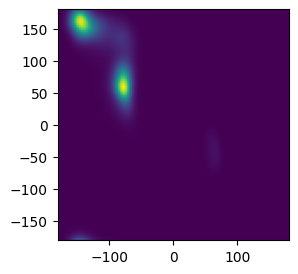

In [137]:
range_=[-180,180]
kt = 0.596161

dx = dy = 2*np.pi/len(metad_fe_sumhills)
prob_metad = np.exp(-metad_fe_sumhills/kt)
prob_metad = prob_metad/numerical_integration_2d_simp(prob_metad,dx,dy)
plt.figure(figsize=(3,3))
plt.imshow(prob_metad,origin='lower',extent=(-180,180,-180,180))

(100, 100)


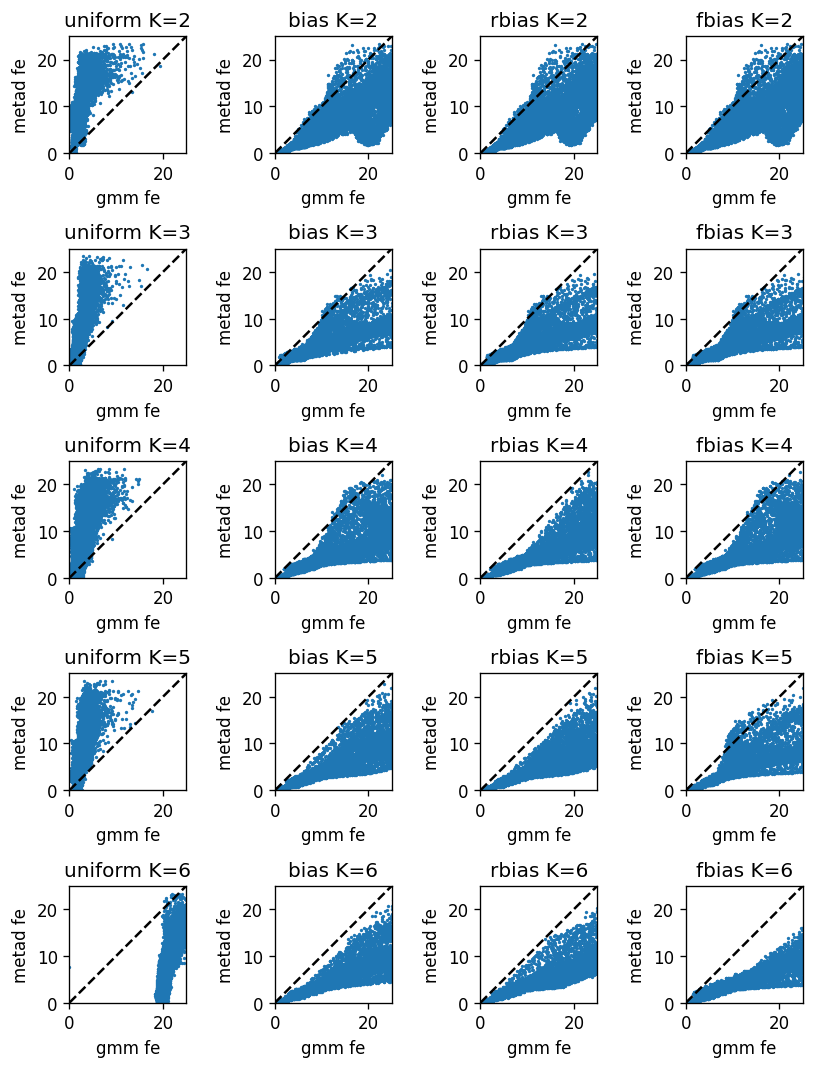

In [138]:
labels = ['uniform','bias','rbias','fbias']
# now get the FEs from SGMM objects ->
fe_sgmm = np.empty((4,5, 100, 100))
kl_errors = np.zeros((4,5))
fig, ax = plt.subplots(5,4,figsize=(7,9),dpi=120)
print(metad_fe_sumhills.shape)
for i in range(4):
    for j in range(5):
        
        H, x, y = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.exp(all_wsgmm[i,j].train_frame_log_likelihood))
        binweight = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.ones(phi.shape[0]))[0]
        fe = -kt*(np.log(H) - np.log(binweight))
        
        fe -= fe[~np.isnan(fe)].min()
        fe_sgmm[i,j,:,:] = fe

        ax[j,i].scatter(fe.T.flatten(),metad_fe_sumhills.flatten(),s=1)
        ax[j,i].plot(np.arange(0,25,0.1),np.arange(0,25,0.1),linestyle='--',c='k')
        ax[j,i].set_title(f'{labels[i]} K={j+2}')
        ax[j,i].set_xlabel('gmm fe')
        ax[j,i].set_ylabel('metad fe')
        ax[j,i].set_xlim(0,25)
        ax[j,i].set_ylim(0,25)
        ax[j,i].set_box_aspect(1)
        dE = fe.T - metad_fe_sumhills
        dE[np.isnan(dE)]=0
        kl_errors[i,j] = numerical_integration_2d_simp(prob_metad/kt*dE,dx,dy)
        
plt.tight_layout()

In [139]:
print(kl_errors)

[[ 0.17965137  0.90587522  0.90422038  1.47061609 31.60328078]
 [ 3.78812961  2.19949263  3.03861028  3.25430995  3.06121499]
 [ 3.74834595  2.53022195  3.1813027   3.1929948   3.17039244]
 [ 3.84749272  2.60067252  2.99349853  3.05869485  3.3196771 ]]


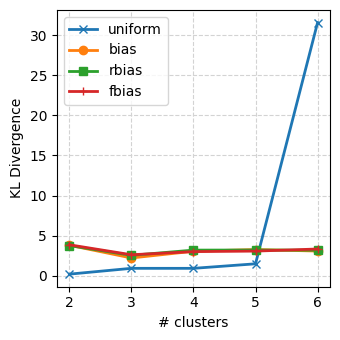

In [140]:
markers = ['x','o','s','+']
plt.figure(figsize=(3.5, 3.5))
plt.xticks([2,3,4,5,6])
plt.ylabel("KL Divergence")
plt.xlabel("# clusters")
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    plt.plot([2,3,4,5,6], kl_errors[i,:], label=labels[i], marker=markers[i], lw=2.0)
#plt.ylim(2.5,4.2)
plt.legend(loc=0)
plt.tight_layout()
plt.savefig("kl_div_fe_sgmm_metad_bf10_all.pdf", format="pdf")

In [141]:
print(fe_sgmm.shape)

(4, 5, 100, 100)


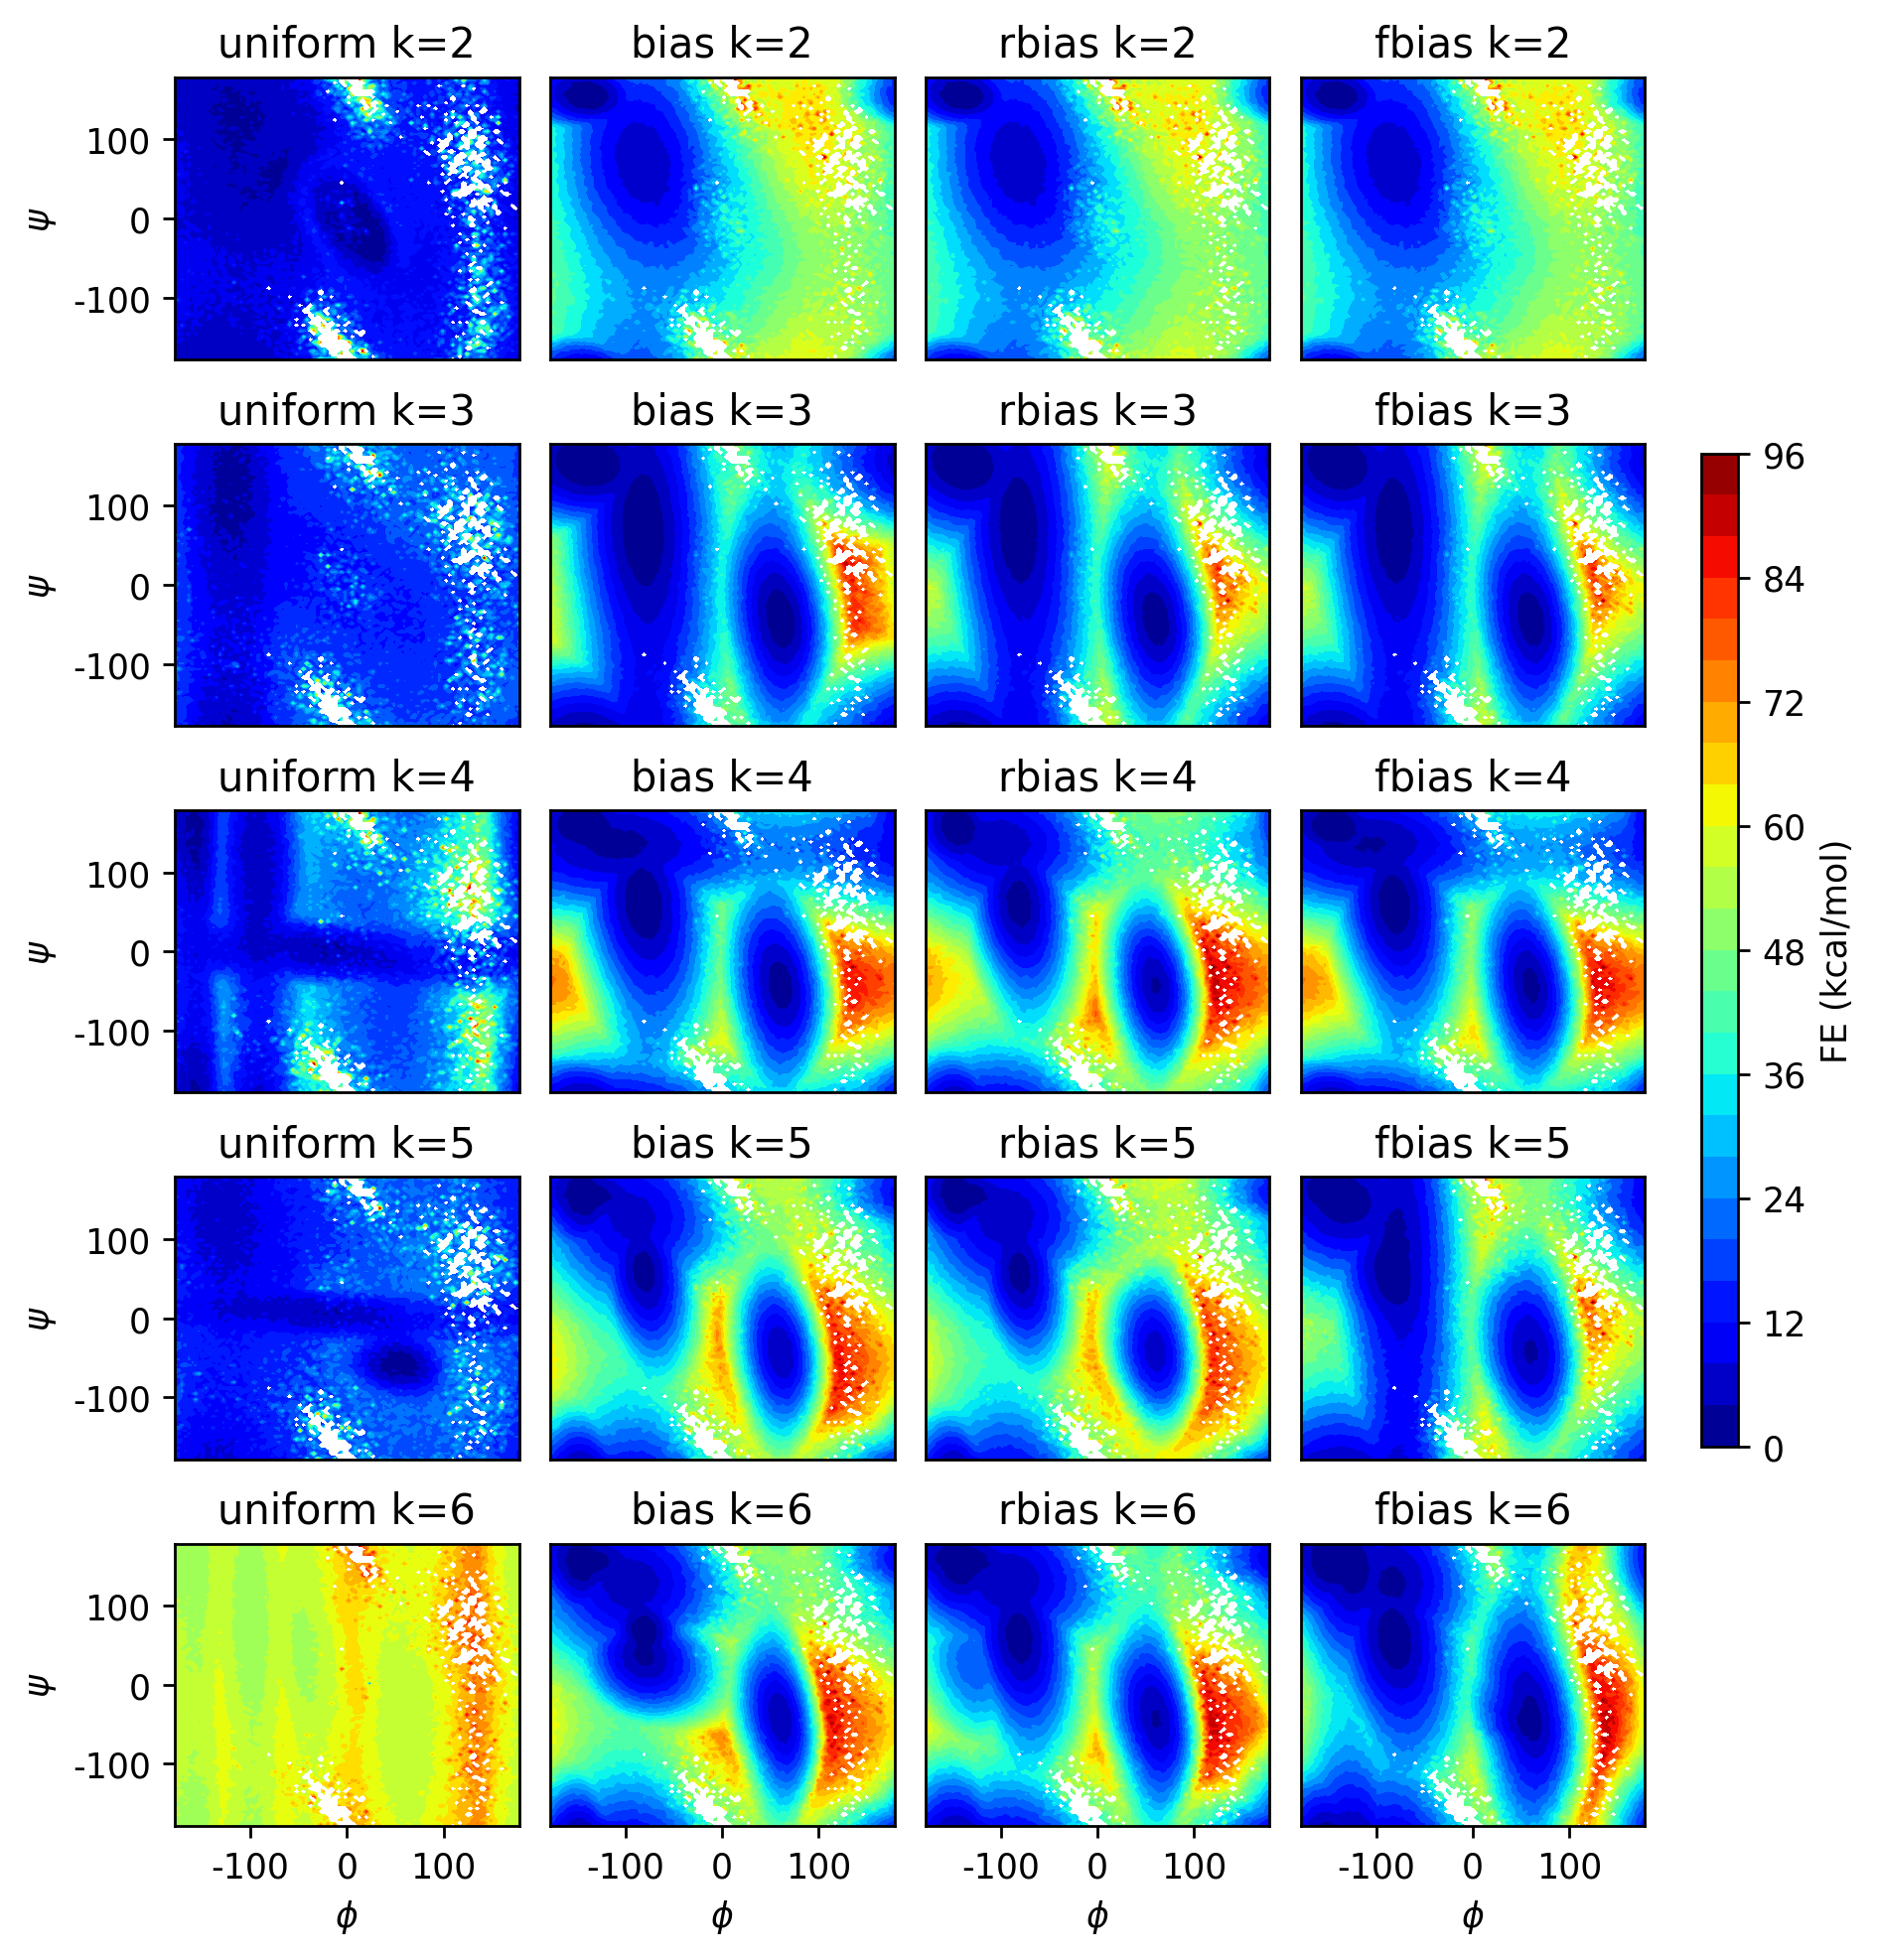

In [142]:
fig, axs  = plt.subplots(5,4, figsize=(7.5,8), dpi=250)
xbins = (x[1:]+x[:-1])/2.0
ybins = (y[1:]+y[:-1])/2.0
bias_labels = ["uniform", "bias", "rbias", "fbias"]

for i in range(4):
    for j in range(5):
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        axs[j,i].set_title(bias_labels[i]+" k=%d"%(j+2))
        im = axs[j,i].contourf(xbins, ybins, fe_sgmm[i,j].T, cmap="jet", levels=25)

# set ylables
for i in range(5):
    axs[i,0].set_yticks([-100,0,100])
    axs[i,0].set_yticklabels([-100,0,100])
    axs[i,0].set_ylabel("$\psi$")

# set xlabels
for i in range(4):
    axs[4,i].set_xticks([-100,0,100])
    axs[4,i].set_xticklabels([-100,0,100])
    axs[4,i].set_xlabel("$\phi$")    
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.265, 0.02, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')

fig.tight_layout(rect=[0,0,0.91,1.0], h_pad=0.9, w_pad=0.9)

plt.savefig("fe_sgmm_all_bf10.png")

In [143]:
print(fe_sgmm.shape)
print(metad_fe_sumhills.shape)

(4, 5, 100, 100)
(100, 100)


## calculate the RMSE between FE profiles -->

In [144]:
rmse_data = np.empty(all_wsgmm.shape)

# loop over weights
for i in range(4):
    
    # loop over cluster sizes 
    for j in range(5):
        
        a = fe_sgmm[i,j].T.flatten()
        a[a > 5.0*kt] = 0  
        
        b =  metad_fe_sumhills.flatten()
        b[b > 5.0*kt] = 0
        
        dE = a - b
        dE[np.isnan(dE)]=0
        
        rmse_data[i,j] = np.sqrt(np.mean(np.square(dE)))

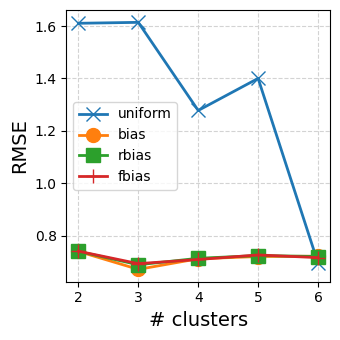

In [145]:
markers = ['x','o','s','+']
plt.figure(figsize=(3.5, 3.5))
plt.xticks([2,3,4,5,6])
plt.ylabel("RMSE", fontsize=14)
plt.xlabel("# clusters", fontsize=14)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    plt.plot([2,3,4,5,6], rmse_data[i,:], label=labels[i], marker=markers[i], lw=2.0, ms=10.0)
#plt.ylim(2.5,4.2)
plt.legend(loc="center left")
plt.tight_layout()
plt.savefig("rmse_fe_data.pdf", format="pdf")